[Changes since first put online:

I have removed plt.show() from the command that used to be display_phases. To display things, you will now need to include that command, and I've renamed the command plot_phases]

# Kuramoto oscillation

The observation that oscillating things often end up curiously coupled dates back to when Huygens invented pendulum clocks in 1656.  He noted that if there were two clocks that were attached to the same piece of wood, the pendulums would tend to either be in phase or exactly out of phase.  [Here is a great example](https://www.youtube.com/watch?v=5v5eBf2KwF8).  You don't even have to watch it, just listen to it.  This sort of behavior has been seen in many other systems since then.  Often (as in the video) all of the oscillators interact.  but in some cases they only interact with physically nearby neighbors, or otherwise on a network.

In the Kuramoto model, we assume that each node $j$ of a network has an associated periodic process happening.  We will refer to the "node" as an "oscillator".  Additionally we assume that each oscillator's state can be described entirely by a phase $\phi_j$ where $0 \leq \phi_j < 2\pi$.

We assume that 
- each oscillator has a natural frequency $\omega_j$ so that $d\phi_j/dt = \omega_j$ in the absence of input from its neighbors.
- the oscillators are coupled so that each neighbor of an oscillator influences the rate that its phase changes, and we assume that this interaction contributes $c \sin[\phi_k(t) - \phi_j(t)]$ to the rate of change of $\phi_j$.  So if $\phi_k>\phi_j$, $\phi_j$ increases faster in an attempt to "catch up", and *vice versa*.
- if the network is directed, only the predecessors $k$ of an oscillator $j$ (i.e., those nodes for which $(k,j)$ is a directed edge) affect $d\phi_j/dt$.

The resulting system of equations is
\begin{equation*}
\frac{d\phi_j}{dt} =  \omega_j + c\sum_{k:\{k,j\}\text{ is an edge}} \sin[\phi_k(t) - \phi_j(t)]
\end{equation*}
where the summation is either over neighbors (in the undirected case) or predecessors (in the directed case).

## Code for simulating Kuramoto oscillators on a network

I'm going to provide some code for you to use to simulate Kuramoto oscillators.

You will need to use networkx commands to generate whatever random graphs you want.

Then you can use this code to simulate the oscillators and display their phases.  Start with smaller networks since solving the differential equations may be a slow process.



In [2]:
import networkx as nx
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt



#First some things that will be needed to find the derivatives.

def phase_deriv(node, X, G, frequencies, c):
    #calculates the derivative of the phase of `node` given the current state
    
    if nx.is_directed(G):  #behaves differently if graph is directed
        phase_differences = [(X[pred] - X[node]) for pred in G.predecessors(node)]
    else:
        phase_differences = [(X[neighbor] - X[node]) for neighbor in G.neighbors(node)]
    sin_phase_diff = np.sin(np.array(phase_differences))
    #sin_phase_diff = map(lambda x: scipy.sin(2*scipy.pi*x), phase_differences)
    Y = sin_phase_diff.sum()
    return frequencies[node] + c*Y


def dphase_dt(X, t, G, frequencies, c):  
    #uses phase_deriv to find the derivative of phases of all nodes.
    dXdt = np.array([phase_deriv(node, X, G, frequencies, c) for node in G.nodes()])
    return dXdt


def solve_model(G, tstop, c = 1, initial_phase = None, natural_frequencies = None, ntimes = 1001):
    r'''
    The arguments of this function are:
    
    G  - a networkx Graph or a DiGraph
    
    tstop   - final time of simulation (assumes that it starts at 0)
    
    c   - an optional argument for the coupling strength, it defaults to 1.
    
    initial_phase - an optional argument giving the initial_phase of all nodes.  
                    Input as a dict.  It defaults to random values in (0, 2pi) for each node
                    
    natural_frequencies - an optional argument giving the natural frequencies of all nodes.
                    Input as a dict.  It defaults to random values in -0.5, 0.5
    
    ntimes - an integer stating how many points between 0 and tstop should be returned.
                    
                    
                    
    the function returns:
    times - an np array of times
    X  - a 2d np array giving the oscillator phase of each node at each time in times.'''
    
    nodelist = list(G.nodes())
    if natural_frequencies is None:
        frequencies =[-0.5+np.random.random() for node in nodelist] 
    else:
        frequencies = [natural_frequencies[node] for node in nodelist]
    if initial_phase is None:
        phase0 = np.array([np.random.random()*2*np.pi for node in nodelist])
    else:
        phase0 = np.array([initial_phase[node] for node in nodelist])
    times = np.linspace(0, tstop, ntimes)
    X = integrate.odeint(dphase_dt, phase0, times, args = (G, frequencies, c))
    
    return times, X
        
def plot_phases(times, X, start_time = None, stop_time = None):
    r''' 
    
    Code for displaying the phases of the oscillators.  
    
    Arguments
    ---------
    
    times - the times returned by solve_model
    X - the phases returned by solve_model
    
    optional Arguments
    ------------------
    start_time   - the time to start the plots at.    default to initial time
    stop_time    - the time to stop the plots at.    default to final time'''
    
    if start_time is None:
        start_index =0
    elif start_time>times[-1]:
        raise ValueError("start_time is greater than times[-1]")
    else:
        start_index = np.argmax(times>=start_time)
    if stop_time is None:
        stop_index = len(times)-1
    elif stop_time < times[0]:
        raise ValueError("stop_time is less than times[0]")
    else:
        stop_index = np.argmax(times>= stop_time)
    if start_index>stop_index:
        raise ValueError("stop_time< start_time")
        
    plt.clf()
    for node in G.nodes():
        x = times[start_index:stop_index]
        y = X[start_index:stop_index, node]%(2*np.pi)
        
        #when we mod out by 2pi, we introduce discontinuities (where it crosses the top a
        #re-enters on the bottom).  These next commands prevent matplotlib from putting vertical
        #lines at those points.
        jumppos = np.where(np.abs(np.diff(y)) >= 1.5*np.pi)[0]+1
        x = np.insert(x, jumppos, np.nan)
        y = np.insert(y, jumppos, np.nan)
        plt.plot(x,y)
    plt.xlabel('times')
    plt.ylabel('phases')


The code is assuming that nodes in `G` are named $0, 1, \ldots, N-1$.  To make sure this is what they are named in your graph, I recommend doing  
`G = nx.convert_node_labels_to_integers(G)`  
just to be sure before calling these functions.

Many of the networkx random graph functions will already have those names, but not all.



### Example

In the example below I build a DIRECTED erdos-renyi network.

Then I run the same thing on an undirected erdos-renyi network.


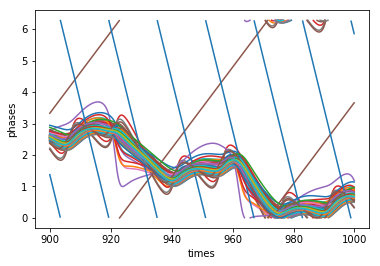

In [3]:
G = nx.fast_gnp_random_graph(100, 0.03, directed=True)
G = nx.convert_node_labels_to_integers(G)  #
times, X = solve_model(G, 1000, c = 2, ntimes = 10001) #running to time 1000
plot_phases(times, X, start_time = 900, stop_time = 1000)
plt.show()



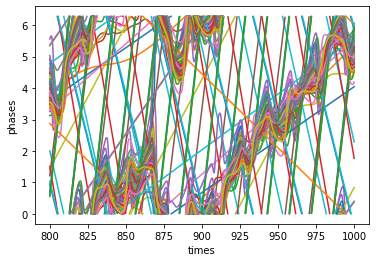

In [57]:
display_phases(times, X, start_time = 1100, stop_time = 1000)


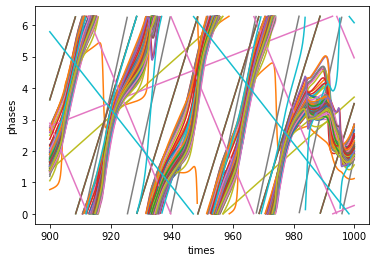

In [36]:
G1 = nx.fast_gnp_random_graph(100, 0.03)
G1 = nx.convert_node_labels_to_integers(G1)  #
times1, X1 = solve_model(G, 1000, c = 4, ntimes = 10001) #running to time 1000
display_phases(times1, X1, start_time = 900, stop_time = 1000)


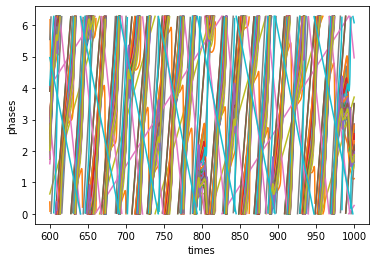

In [38]:
display_phases(times1, X1, start_time = 600, stop_time = 1000)


Please try your own examples, playing with coupling strength `c`, and different graph types.  You may want to use a smaller final time in `solve_model` (I used 1000).

In [60]:
import pickle

In [63]:
pickle.dump({'Graph':G1, 'times':times, 'data':X, 'c':4},open( "weird_oscillation.p", "wb" ))